<a href="https://colab.research.google.com/github/jpsilverio1213/practicas-finales-ml-u3-u4/blob/main/Copia_de_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In Depth: Decision Trees and Random Forests

Previously we have looked in depth at a simple generative classifier (naive Bayes; see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)) and a powerful discriminative classifier (support vector machines; see [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)).
Here we'll take a look at another powerful algorithm: a nonparametric algorithm called *random forests*.
Random forests are an example of an *ensemble* method, meaning one that relies on aggregating the results of a set of simpler estimators.
The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, the predictive accuracy of a majority vote among a number of estimators can end up being better than that of any of the individual estimators doing the voting!
We will see examples of this in the following sections.

We begin with the standard imports:

Ahora el texto presenta otro método que también es muy bueno, llamado random forests o bosques aleatorios. Este método no se basa en una sola fórmula fija, sino que es más flexible (por eso se dice que es “no paramétrico”).

La idea principal es que no usamos un solo modelo, sino muchos modelos simples al mismo tiempo, y luego combinamos sus respuestas. A este tipo de enfoque se le llama método de ensamble.

Es como preguntar la opinión a muchas personas y quedarte con la mayoría: a veces el grupo acierta más que la persona “más lista” dentro del grupo.

Después de explicar esto, el texto dice que más adelante mostrarán ejemplos y que primero van a hacer las importaciones estándar en el código (es decir, cargar las librerías de Python que se usan siempre para este tipo de cosas).

In [1]:
!pip install seaborn
import seaborn as sns

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

## Motivating Random Forests: Decision Trees

Random forests are an example of an ensemble learner built on decision trees.
For this reason, we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero in on the classification.
For example, if you wanted to build a decision tree to classify animals you come across while on a hike, you might construct the one shown in the following figure.

Los random forests (bosques aleatorios) son un ejemplo de modelo de ensamble construido a partir de árboles de decisión.
(Es decir, no es un solo árbol, sino muchos árboles trabajando juntos.)
Por esta razón, primero vamos a hablar de los propios árboles de decisión.

Los árboles de decisión son una forma muy intuitiva de clasificar o etiquetar objetos: simplemente vas haciendo una serie de preguntas pensadas para acercarte cada vez más a la clase correcta.
(Es como un juego de “sí o no” que te va guiando hasta la respuesta.)

Por ejemplo, si quisieras construir un árbol de decisión para clasificar animales que te encuentras durante una caminata, podrías armar algo parecido al que se muestra en la figura siguiente.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Example)

The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes.
The trick, of course, comes in deciding which questions to ask at each step.
In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.
Let's now look at an example of this.

La división binaria hace que este proceso sea extremadamente eficiente: en un árbol bien construido, cada pregunta reduce el número de opciones aproximadamente a la mitad, lo que permite acotar muy rápido las posibilidades incluso cuando hay muchas clases distintas.
(O sea, con cada “sí/no” vas descartando un montón de opciones de golpe.)

El truco, por supuesto, está en decidir qué preguntas hacer en cada paso. En las implementaciones de árboles de decisión dentro del aprendizaje automático, estas preguntas suelen tomar la forma de divisiones alineadas con los ejes en los datos: es decir, cada nodo del árbol separa los datos en dos grupos usando un valor de corte en una de las características.
(En la práctica, es como decir: “si la altura > 1.70, ve a la derecha; si no, ve a la izquierda”.)

### Creating a Decision Tree

Consider the following two-dimensional data, which has one of four class labels (see the following figure):

Considere los siguientes datos bidimensionales, que tienen una de cuatro etiquetas de clase (consulte la siguiente figura):

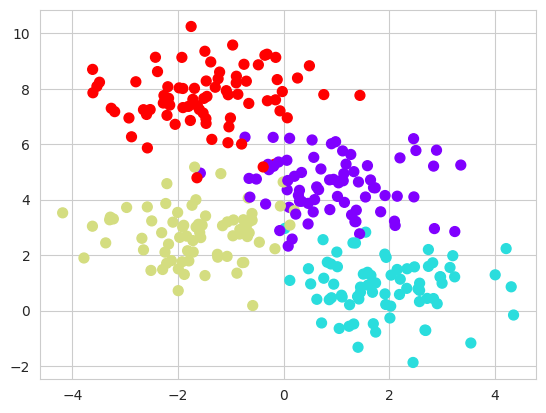

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.
The following figure presents a visualization of the first four levels of a decision tree classifier for this data.


Un árbol de decisión simple, construido con estos datos, dividirá iterativamente los datos a lo largo de uno u otro eje según un criterio cuantitativo, y en cada nivel asignará la etiqueta de la nueva región según la mayoría de los puntos dentro de ella. La siguiente figura presenta una visualización de los primeros cuatro niveles de un clasificador de árbol de decisión para estos datos.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-levels.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

Observe que, tras la primera división, todos los puntos de la rama superior permanecen inalterados, por lo que no es necesario subdividirla. Salvo los nodos que contienen todos un color, en cada nivel cada región se divide de nuevo a lo largo de una de las dos entidades.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the ``DecisionTreeClassifier`` estimator:

Este proceso de ajuste de un árbol de decisión a nuestros datos se puede realizar en Scikit-Learn con el estimador DecisionTreeClassifier:

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Let's write a utility function to help us visualize the output of the classifier:


Escribamos una función de utilidad para ayudarnos a visualizar la salida del clasificador:

In [5]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what the decision tree classification looks like (see the following figure):

Ahora podemos examinar cómo se ve la clasificación del árbol de decisión (ver la siguiente figura):

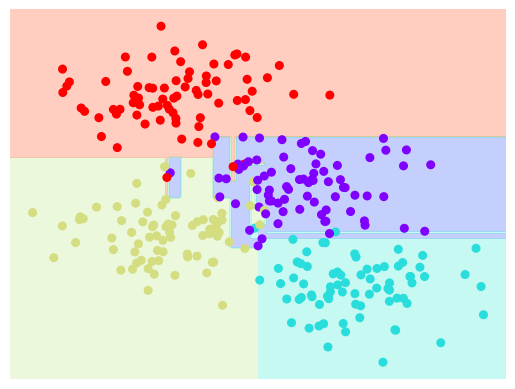

In [6]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [9]:

import helpers
helpers.plot_tree_interactive(X, y);

interactive(children=(IntSlider(value=5, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions.
It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data.
That is, this decision tree, even at only five levels deep, is clearly overfitting our data.

A medida que aumenta la profundidad del árbol, empezamos a obtener regiones de clasificación con formas muy extrañas; por ejemplo, con una profundidad de cinco aparece una región morada muy alta y delgada entre las regiones amarilla y azul.
(O sea, el modelo dibuja fronteras muy raras solo para acomodarse a casos muy específicos.)

### Decision Trees and Overfitting

Such overfitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions it is drawn from.
Another way to see this overfitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data.

Ese sobreajuste resulta ser una característica bastante general de los árboles de decisión: es muy fácil hacer que el árbol tenga demasiados niveles y termine ajustándose a detalles específicos del conjunto de datos, en lugar de capturar las propiedades generales de la distribución de la que provienen.
(En otras palabras, el árbol se obsesiona con el “caso particular” y se olvida de la “idea general”.)

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

It is clear that in some places the two trees produce consistent results (e.g., in the four corners), while in other places the two trees give very different classifications (e.g., in the regions between any two clusters).
The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result!

Es claro que, en algunas zonas, los dos árboles producen resultados coherentes entre sí (por ejemplo, en las cuatro esquinas), mientras que en otras partes dan clasificaciones muy diferentes (como en las regiones que quedan entre dos clústeres).
(O sea, hay áreas donde los modelos “se ponen de acuerdo” y otras donde cada uno dice algo distinto.)

If you are running this notebook live, the following function will allow you to interactively display the fits of trees trained on a random subset of the data:

Si está ejecutando este cuaderno en vivo, la siguiente función le permitirá mostrar de forma interactiva los ajustes de los árboles entrenados en un subconjunto aleatorio de los datos:

In [10]:
# helpers_05_08 is found in the online appendix
import helpers
helpers.randomized_tree_interactive(X, y)

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…

Just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.

## Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which overfits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

This type of bagging classification can be done manually using Scikit-Learn's `BaggingClassifier` meta-estimator, as shown here (see the following figure):

Esta idea —que varios estimadores sobreajustados pueden combinarse para reducir el efecto de ese sobreajuste— es lo que está detrás de un método de ensamble llamado bagging.
(Básicamente, en lugar de confiar en un solo modelo "exagerado", usamos muchos y promediamos sus respuestas.)

El bagging utiliza un conjunto (una "bolsa", por así decirlo) de estimadores que trabajan en paralelo, cada uno sobreajustando los datos, y luego promedia los resultados para encontrar una clasificación mejor.
(Es como pedirle opinión a varias personas que se equivocan de formas distintas: al promediar, los errores se compensan.)

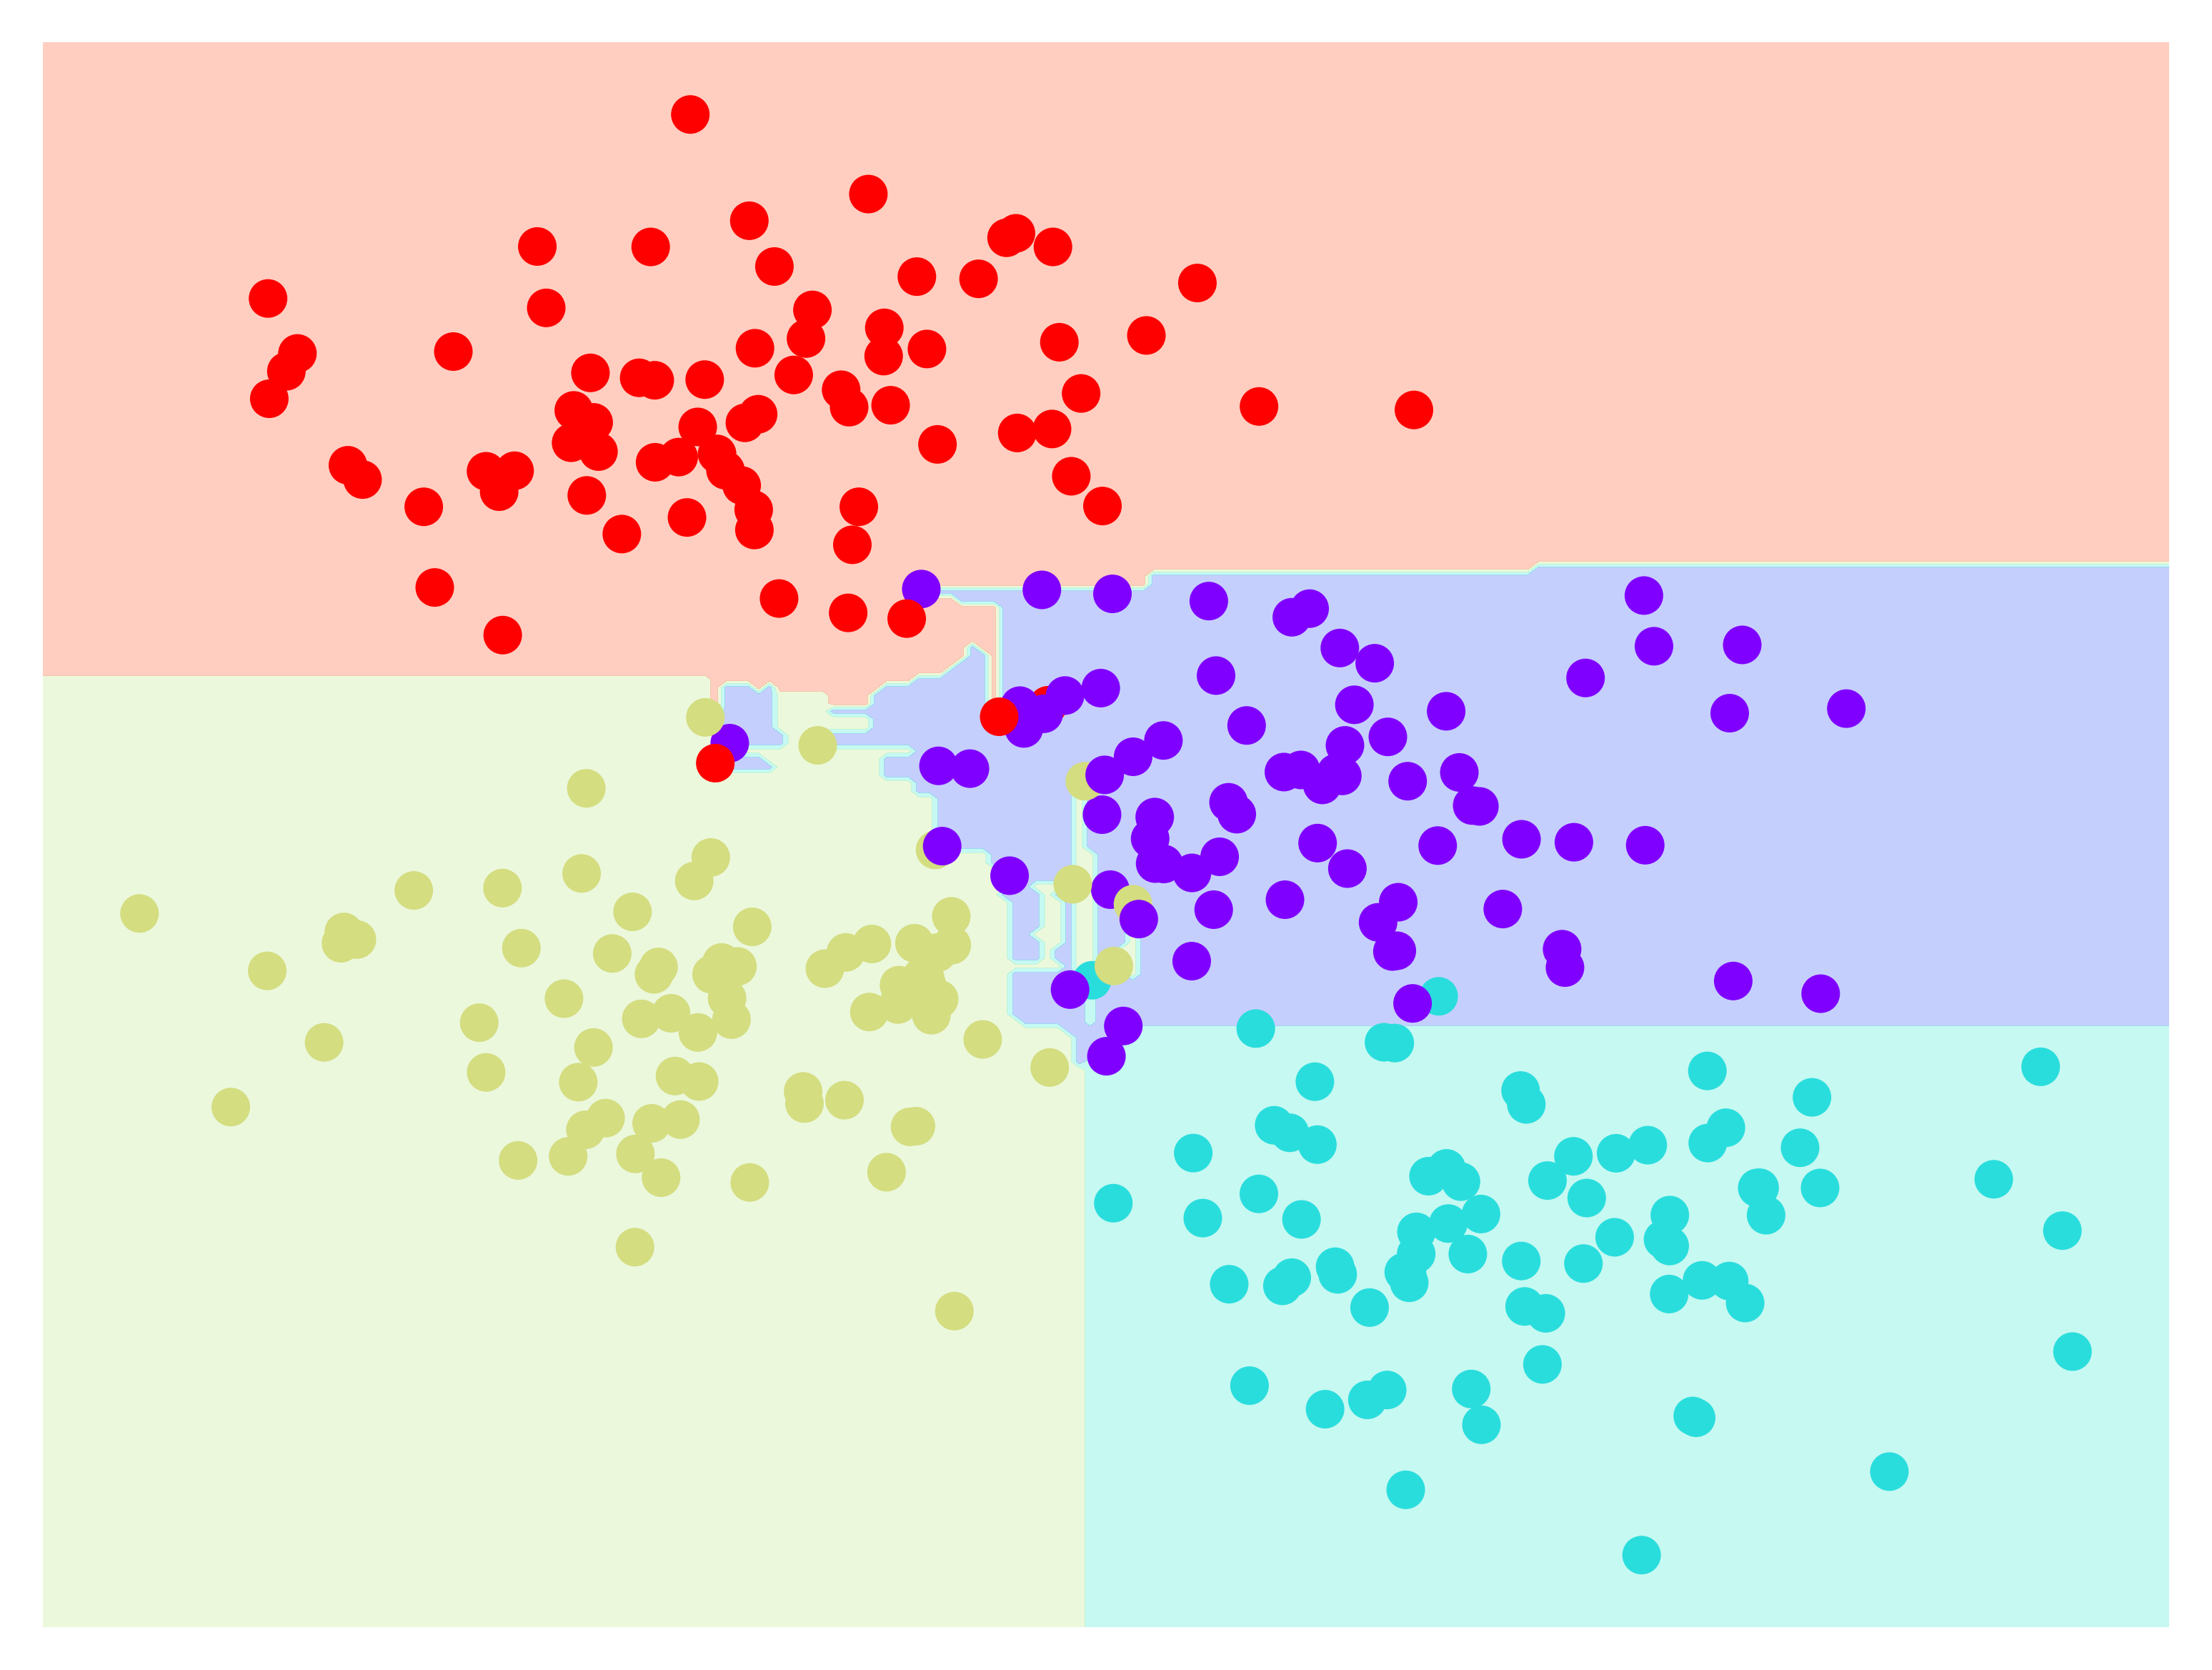

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the `RandomForestClassifier` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly—in parallel, if desired—fit the ensemble of trees (see the following figure):

En este ejemplo, hemos aleatorizado los datos ajustando cada estimador con un subconjunto aleatorio que contiene el 80 % de los puntos de entrenamiento.
(O sea, cada modelo ve una muestra distinta de los datos, no exactamente el mismo conjunto completo.)

En la práctica, los árboles de decisión se pueden aleatorizar de forma más efectiva metiendo algo de azar en la forma en que se eligen las divisiones. De esta manera, todos los datos contribuyen al ajuste cada vez, pero los resultados siguen teniendo la dosis de aleatoriedad que buscamos.
Por ejemplo, cuando se decide qué característica usar para dividir, el árbol aleatorizado podría elegir al azar entre las mejores características en lugar de escoger siempre la número uno.
(Eso evita que todos los árboles se vean casi iguales.)

Puedes leer más detalles técnicos sobre estas estrategias de aleatorización en la documentación de Scikit-Learn y en las referencias que allí se mencionan.

En Scikit-Learn, este tipo de ensamble optimizado de árboles de decisión aleatorizados está implementado en el estimador RandomForestClassifier, que se encarga automáticamente de toda la parte aleatoria.
Tú solo tienes que elegir cuántos árboles (estimadores) quieres, y la librería se ocupa de ajustar muy rápido —en paralelo, si así lo configuras— todo el conjunto de árboles (ver la figura siguiente).
(En resumen: escoges el número de árboles y Scikit-Learn hace la “magia” por detrás.)

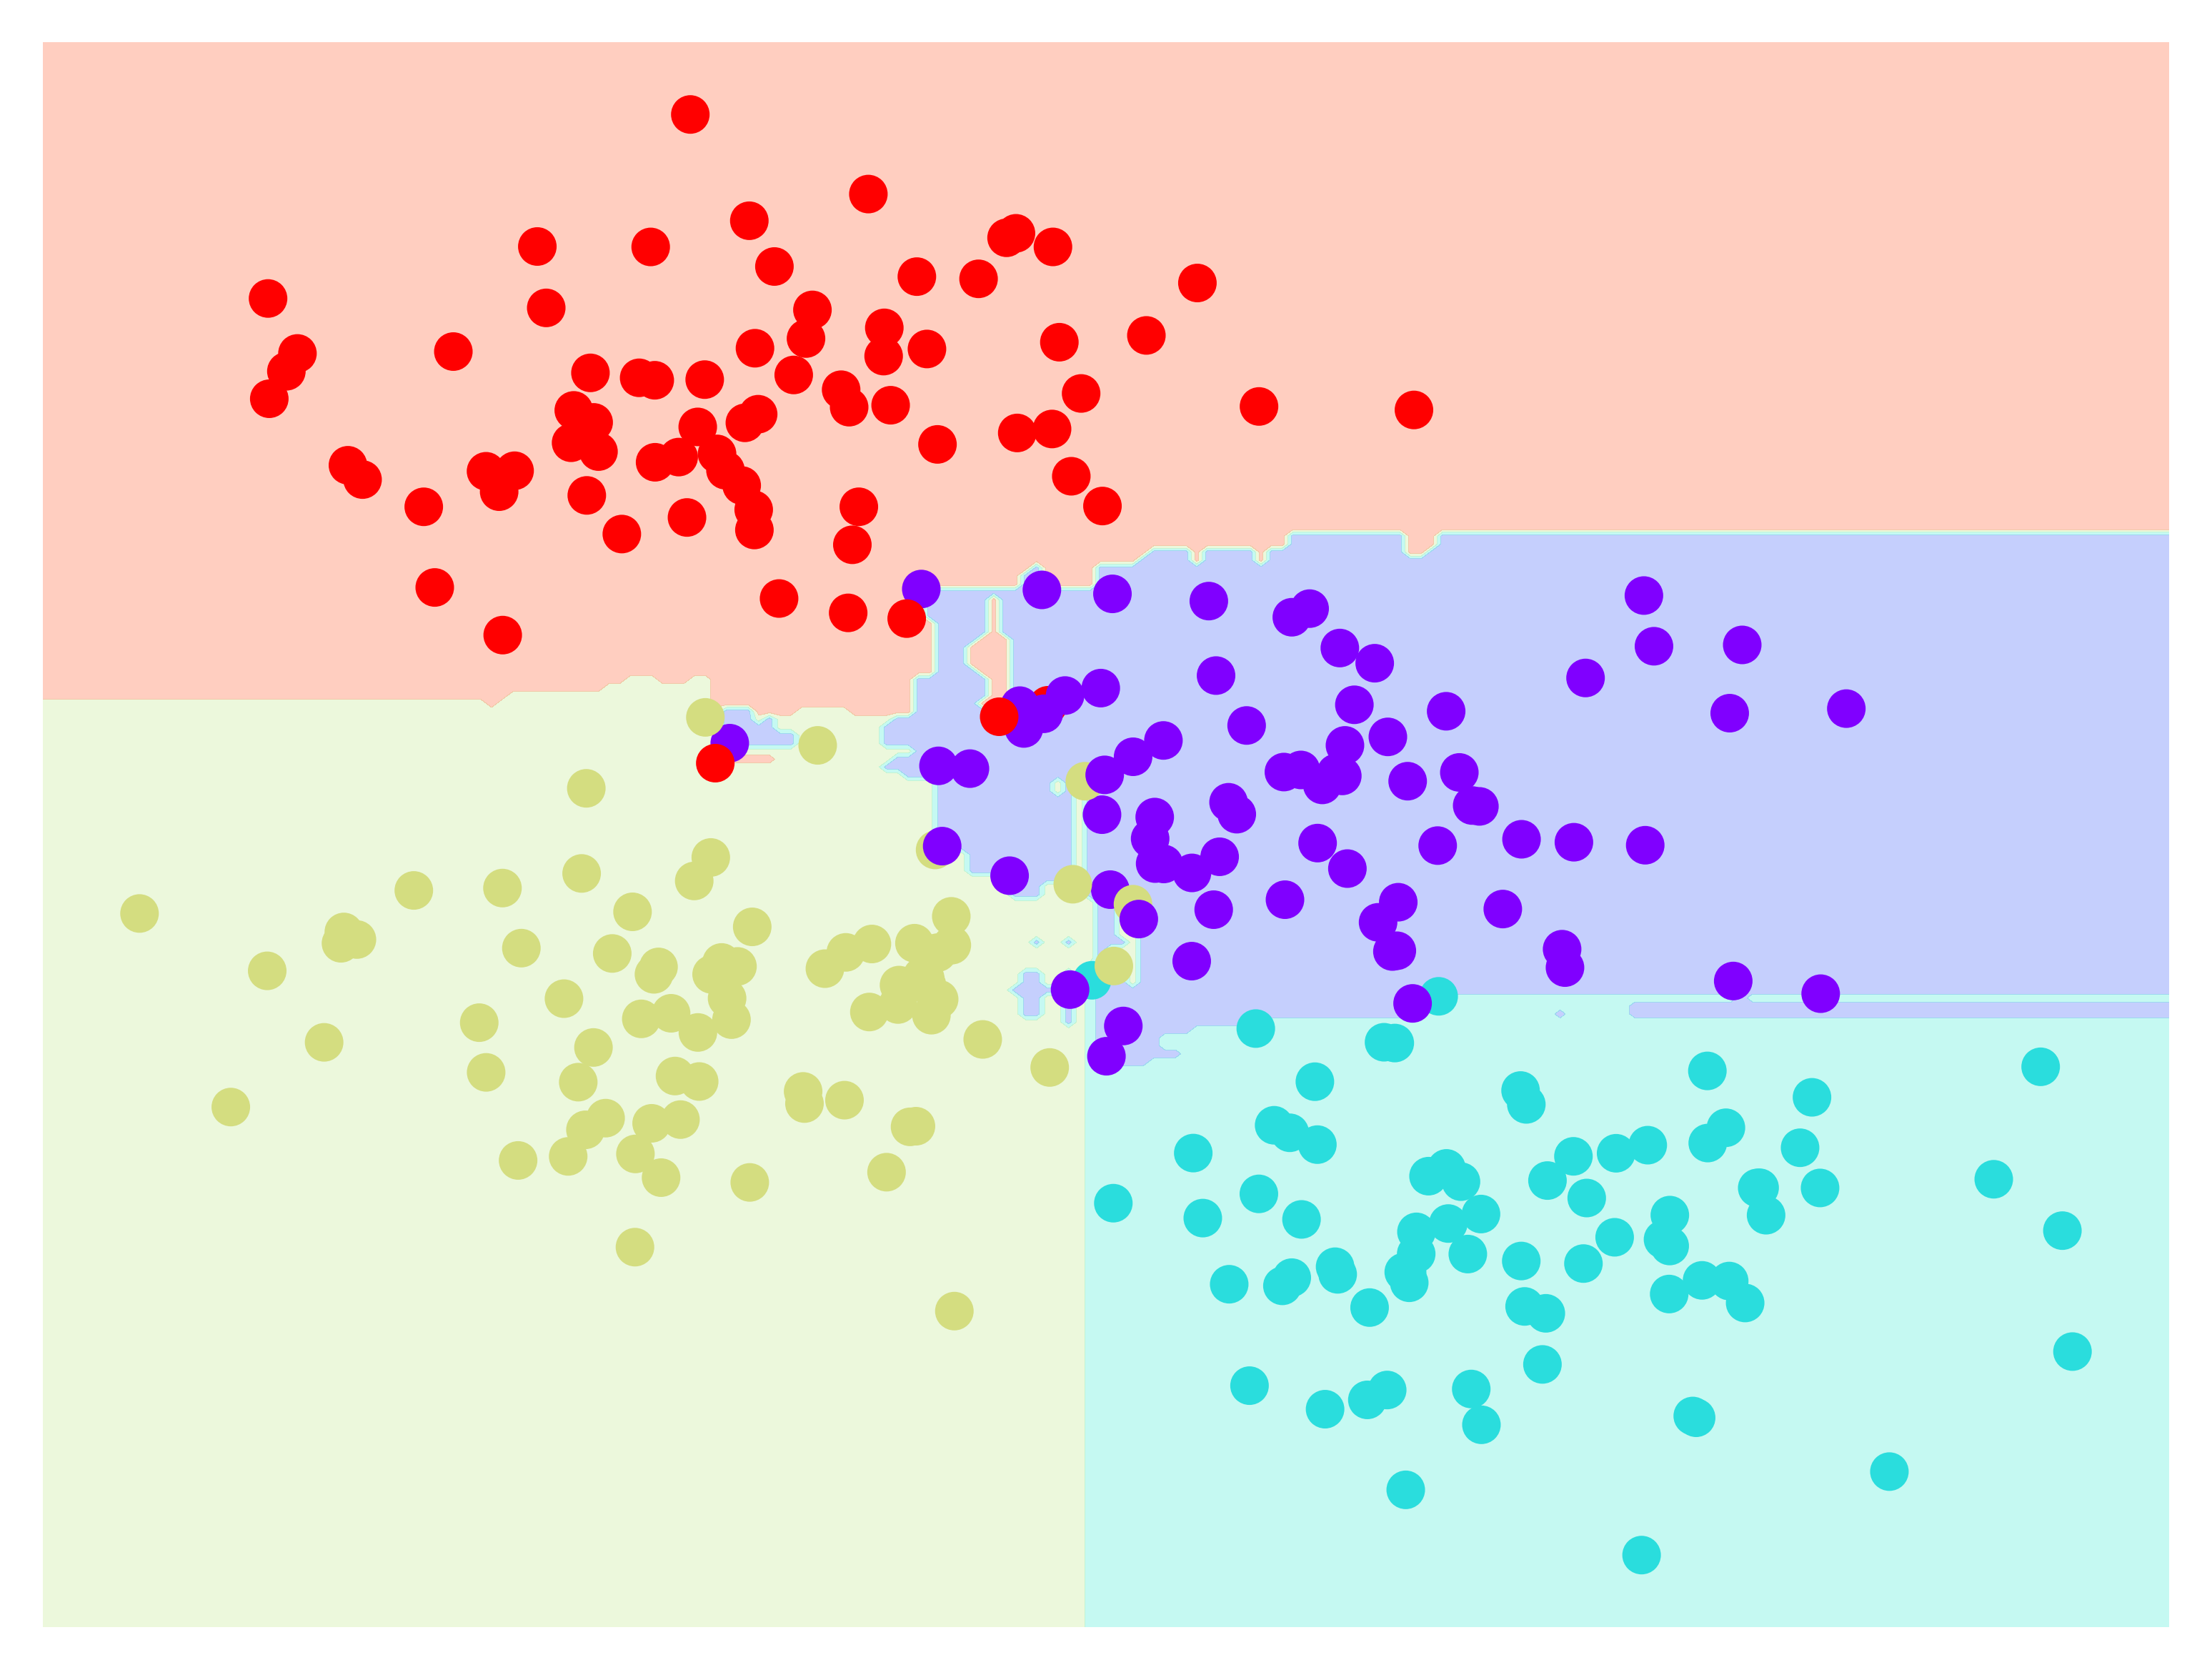

In [12]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, with continuous rather than categorical variables). The estimator to use for this is the `RandomForestRegressor`, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation (see the following figure):

En la sección anterior, consideramos los bosques aleatorios en el contexto de la clasificación. Los bosques aleatorios también pueden funcionar en el caso de la regresión (es decir, con variables continuas en lugar de categóricas). El estimador que se utiliza para esto es el RandomForestRegressor, y la sintaxis es muy similar a la que vimos anteriormente.

Considere los siguientes datos, obtenidos de la combinación de una oscilación rápida y una lenta (véase la siguiente figura):

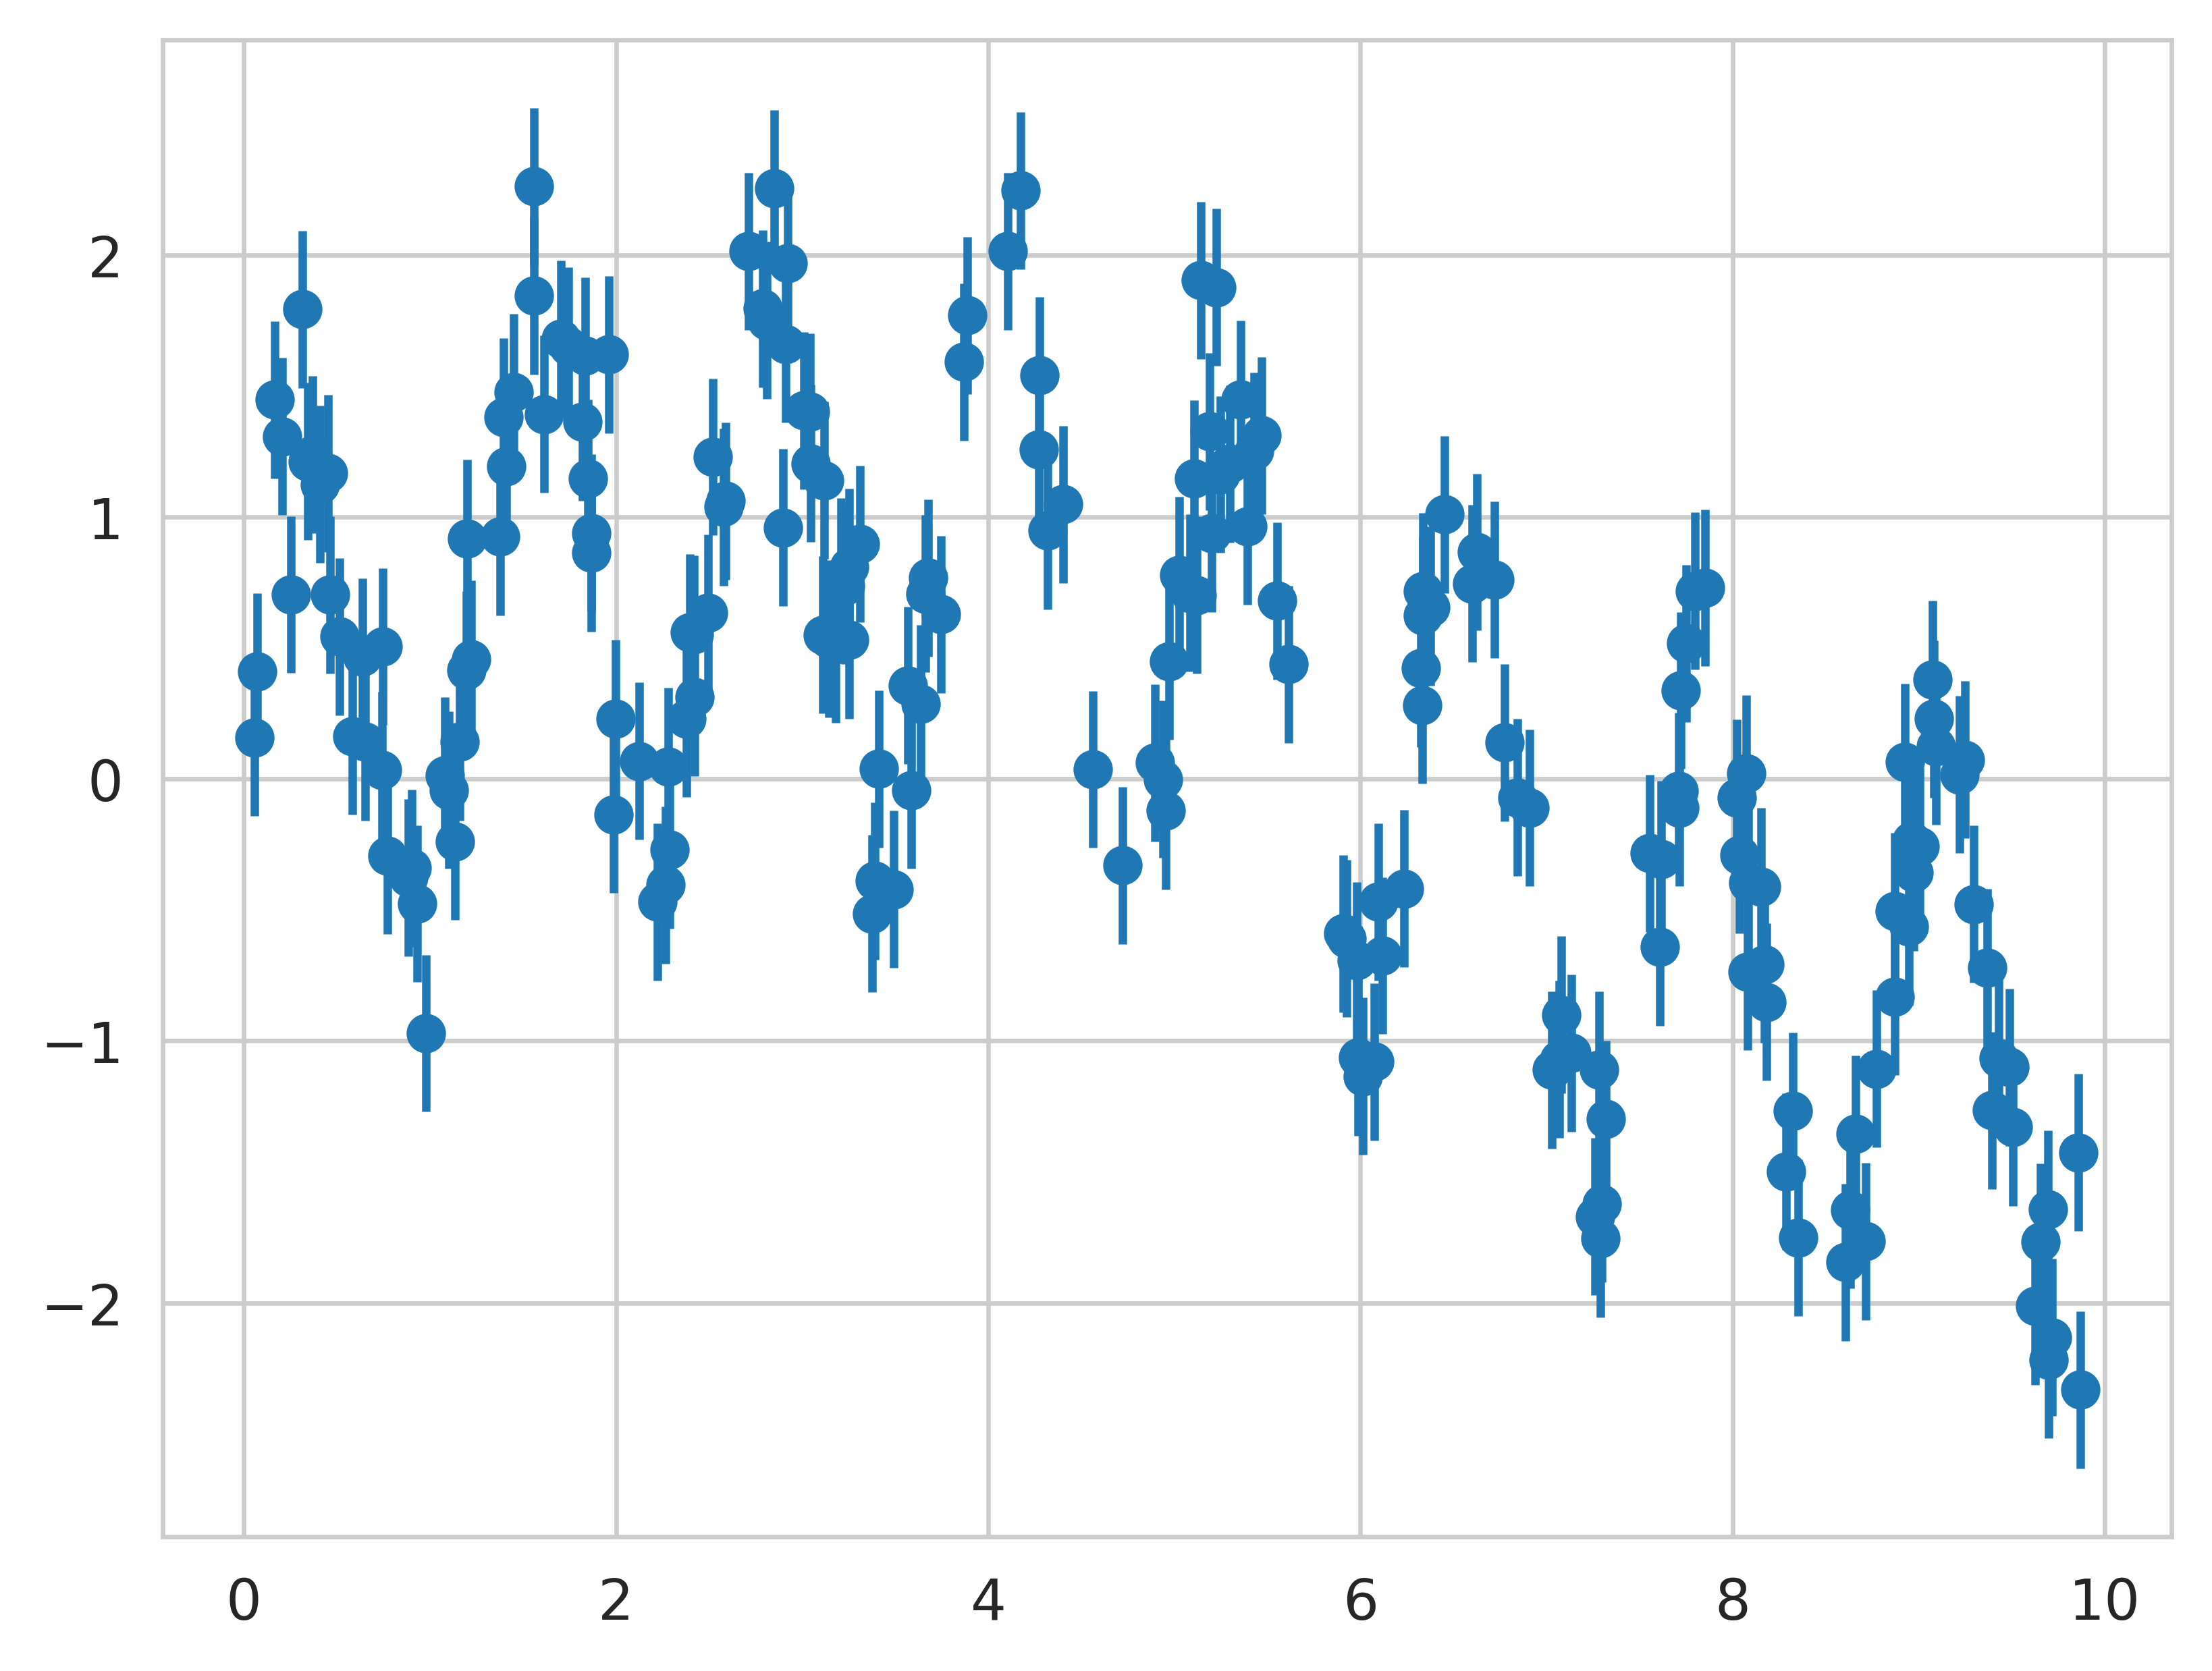

In [13]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best-fit curve as follows (see the following figure):

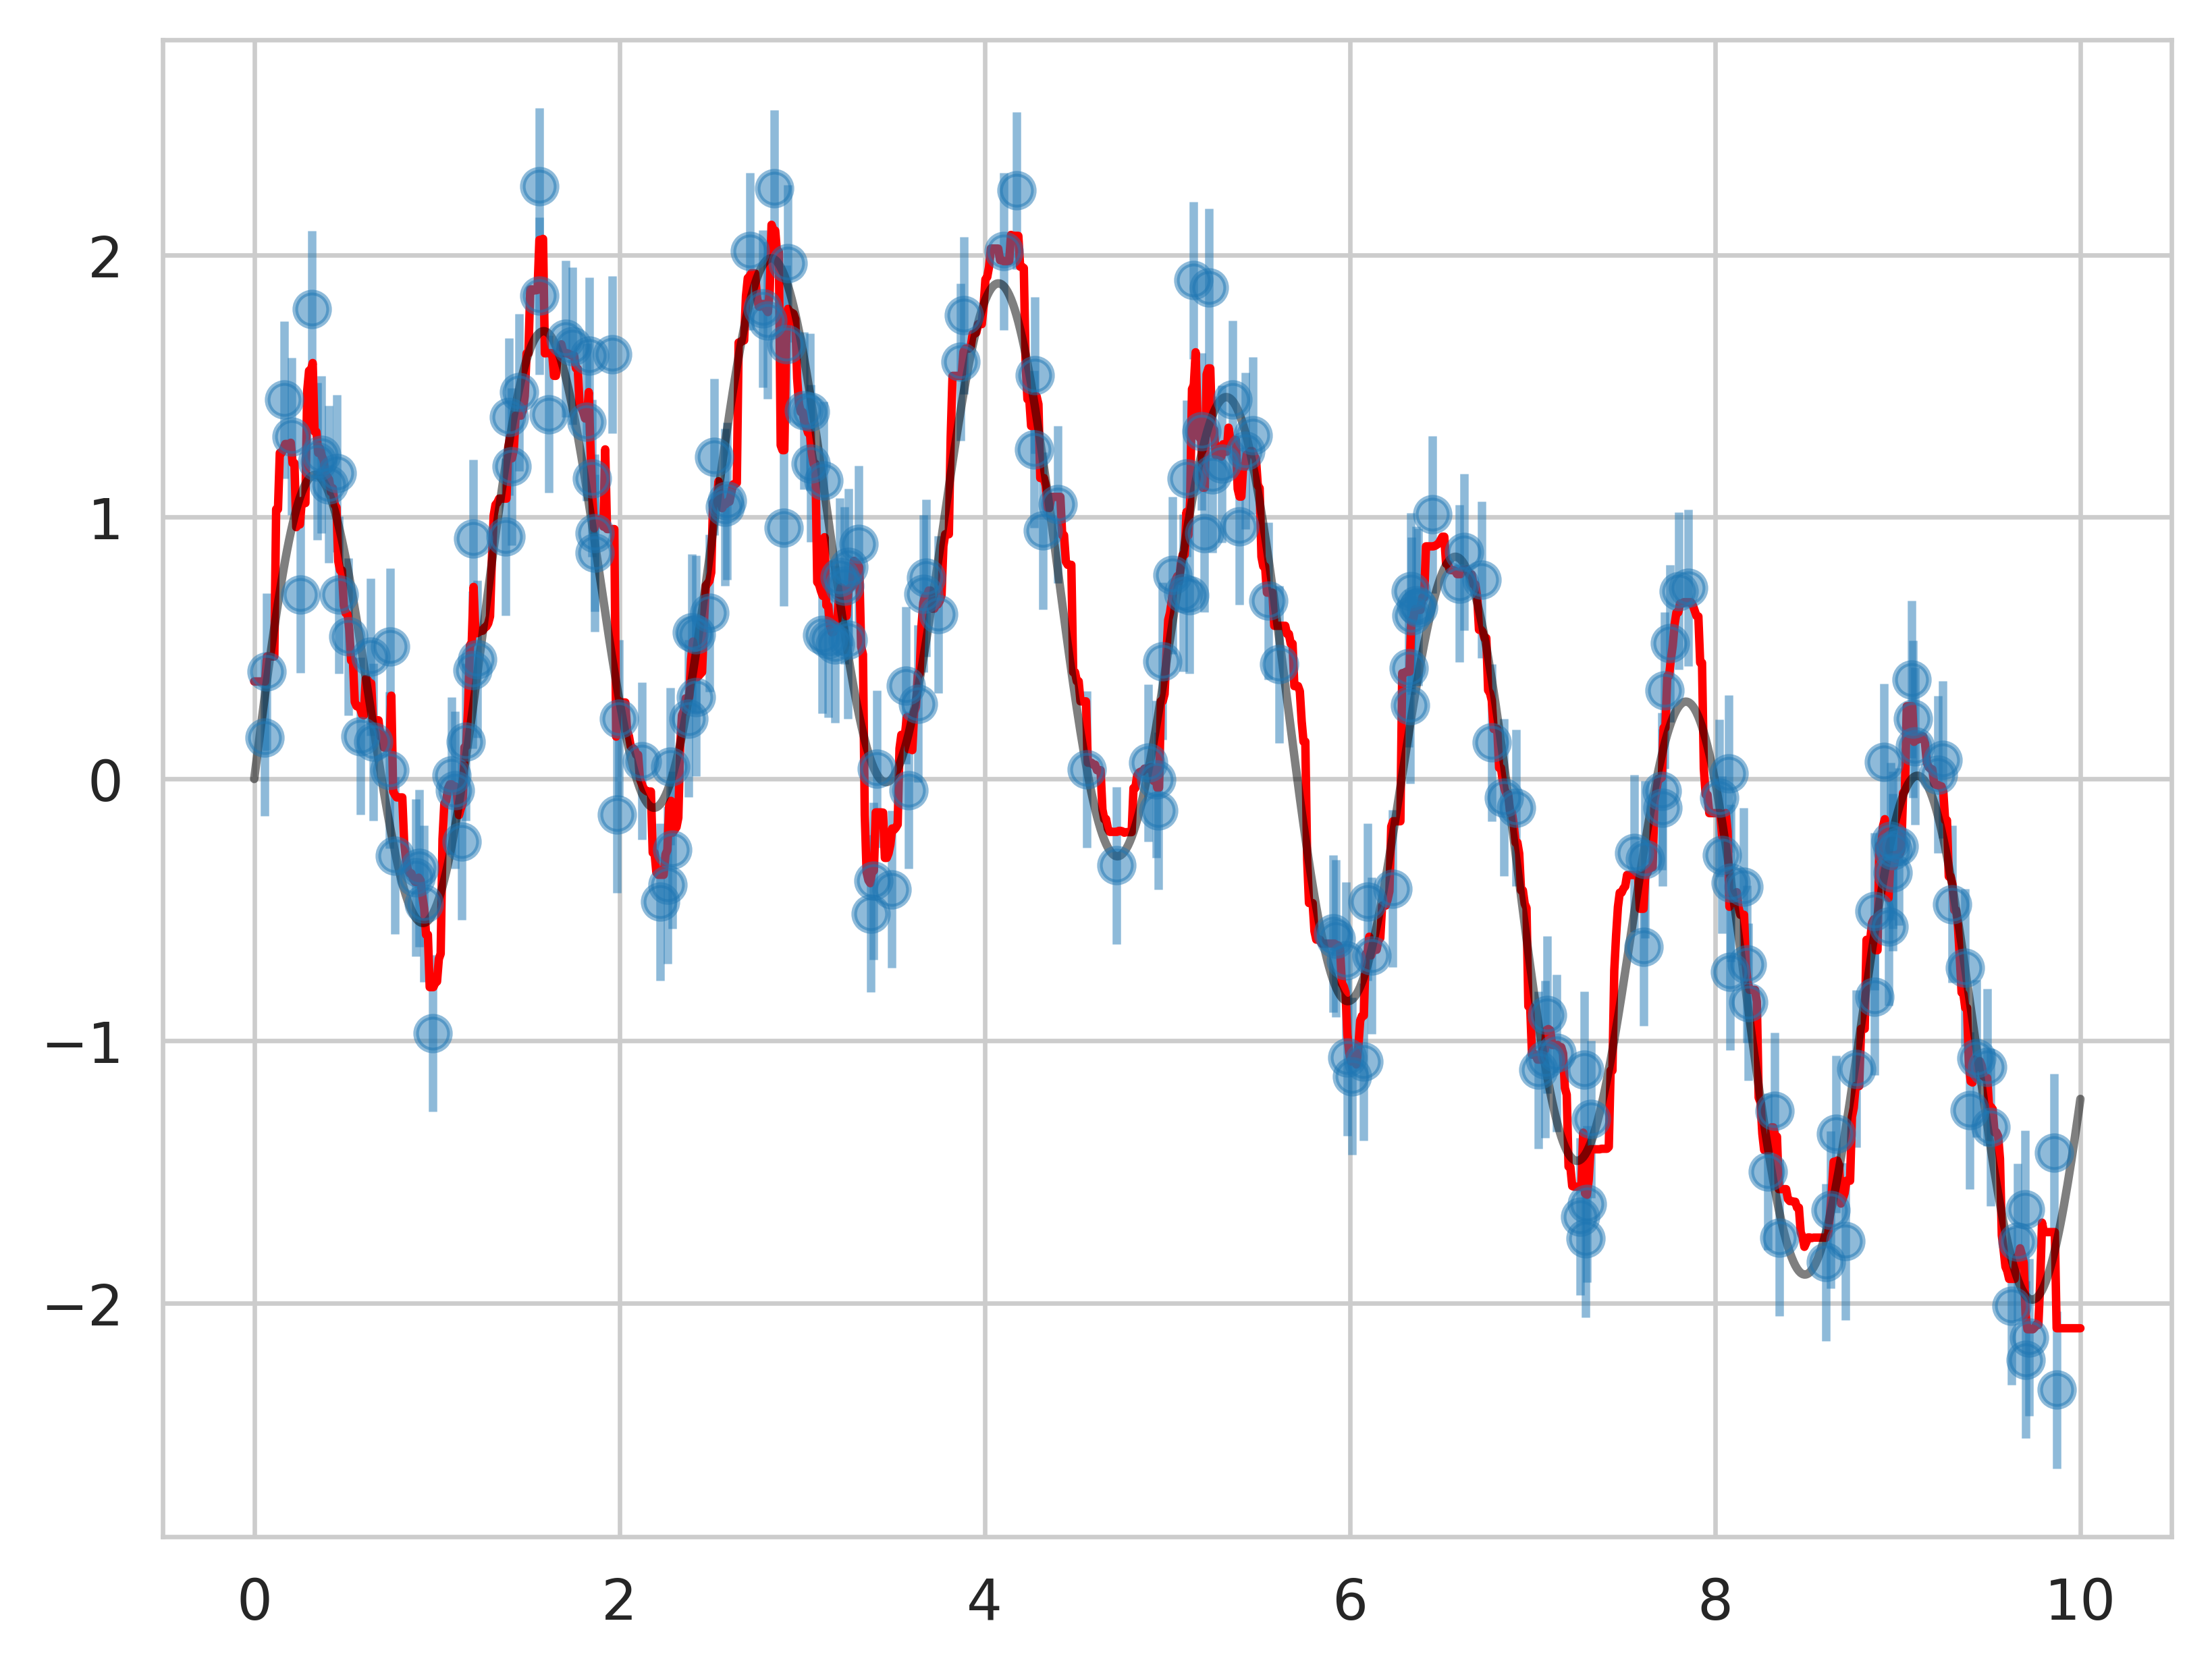

In [14]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
The nonparametric random forest model is flexible enough to fit the multiperiod data, without us needing to specifying a multi-period model!

Aquí, el modelo real se muestra en la curva gris suave, mientras que el modelo de bosque aleatorio se muestra en la curva roja irregular. El modelo de bosque aleatorio no paramétrico es lo suficientemente flexible como para ajustarse a los datos multiperiodo, sin necesidad de especificar un modelo multiperiodo.


## Example: Random Forest for Classifying Digits

In Chapter 38 we worked through an example using the digits dataset included with Scikit-Learn.
Let's use that again here to see how the random forest classifier can be applied in this context:

Ejemplo: Bosque aleatorio para clasificar dígitos


En el capítulo 38, trabajamos con un ejemplo utilizando el conjunto de datos de dígitos incluido en Scikit-Learn. Utilicémoslo de nuevo para ver cómo se puede aplicar el clasificador de bosque aleatorio en este contexto:

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

To remind us what we're looking at, we'll visualize the first few data points (see the following figure):

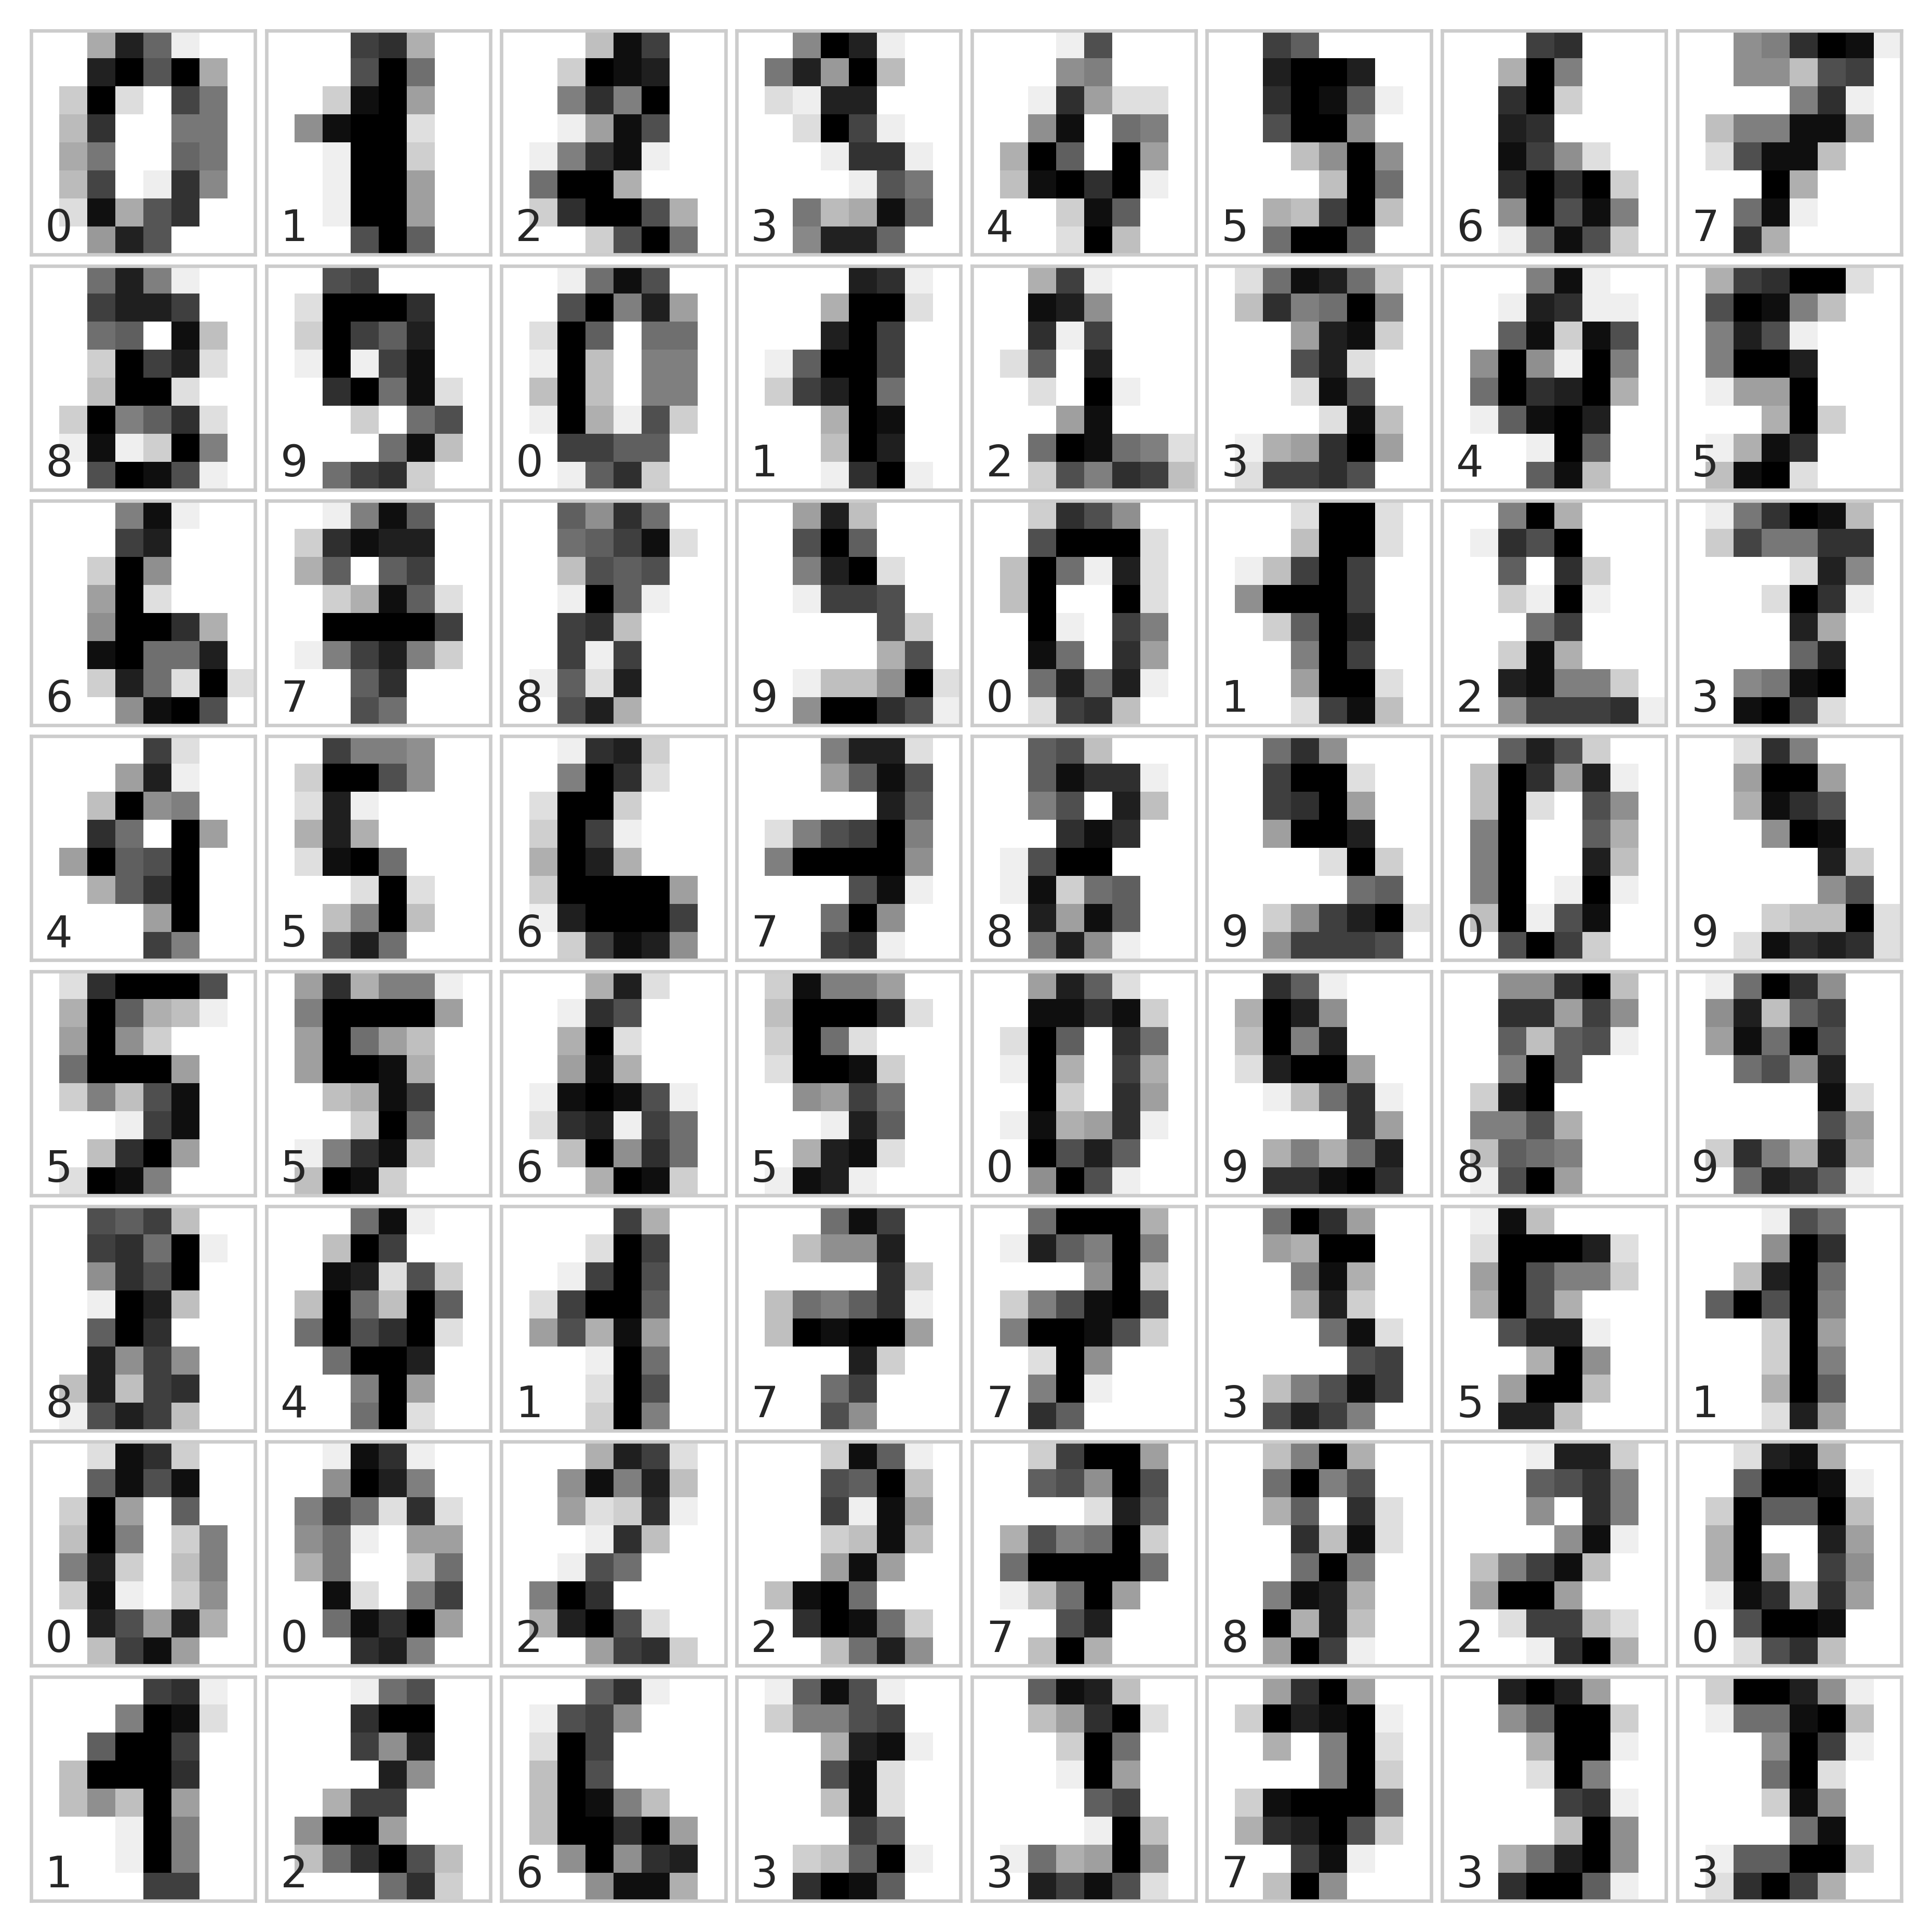

In [16]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can classify the digits using a random forest as follows:

In [17]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Let's look at the classification report for this classifier:

In [18]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix (see the following figure):

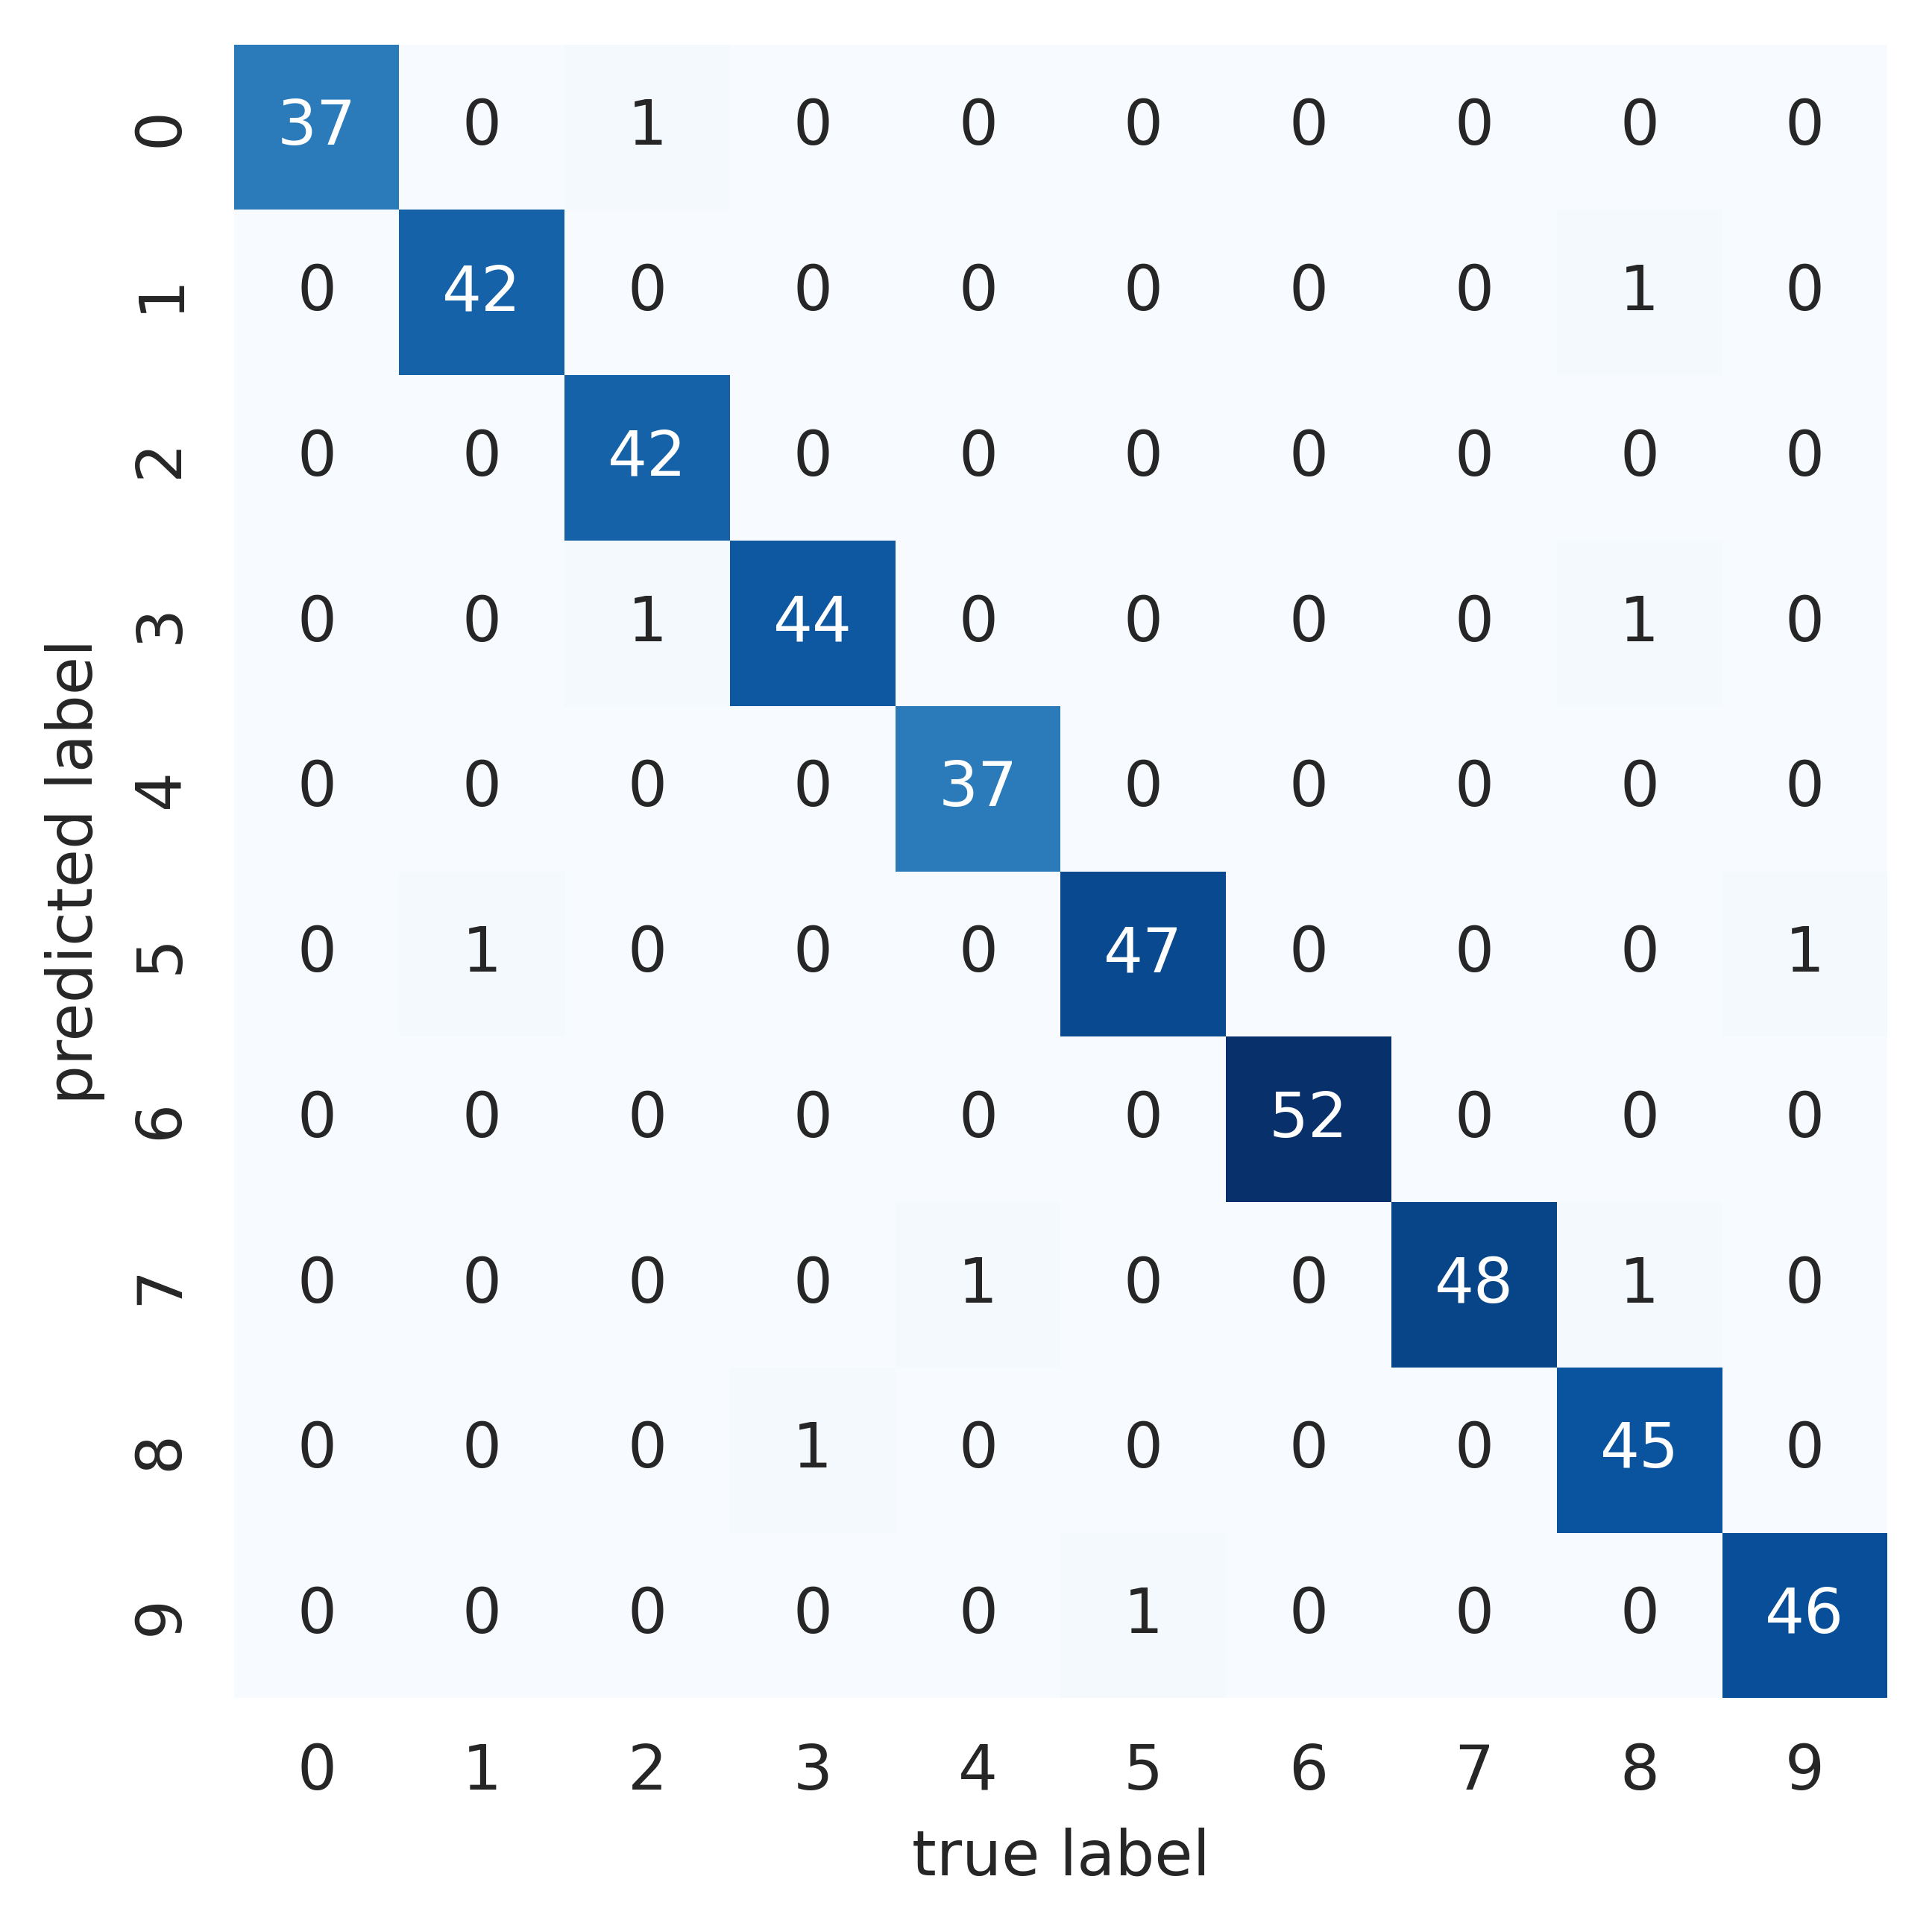

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

We find that a simple, untuned random forest results in a quite accurate classification of the digits data.

## Summary

This chapter provided a brief introduction to the concept of ensemble estimators, and in particular the random forest, an ensemble of randomized decision trees.
Random forests are a powerful method with several advantages:

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the `predict_proba` method).
- The nonparametric model is extremely flexible and can thus perform well on tasks that are underfit by other estimators.

A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.

Resumen

Este capítulo presentó una breve introducción al concepto de estimadores de ensamble y, en particular, al random forest, que es un conjunto de árboles de decisión aleatorizados. Los random forests son un método muy potente y tienen varias ventajas:

Entrenamiento y predicción muy rápidos, gracias a la simplicidad de los árboles de decisión que los componen. Además, ambas tareas se pueden paralelizar de forma bastante directa, porque cada árbol es una entidad completamente independiente.
(En la práctica, puedes entrenar muchos árboles al mismo tiempo en distintos núcleos de la CPU.)

Al tener muchos árboles, se puede hacer una clasificación probabilística: el voto mayoritario entre los estimadores nos da una estimación de la probabilidad de cada clase
(en Scikit‑Learn se obtiene con el método predict_proba).

Al ser un modelo no paramétrico, es extremadamente flexible y puede funcionar muy bien en problemas donde otros modelos se quedan cortos y subajustan los datos.
(Es decir, puede capturar relaciones complejas sin que tengamos que definir una forma específica de antemano.)

La principal desventaja de los random forests es que sus resultados no son fáciles de interpretar: si tu objetivo es entender con claridad por qué se toma cierta decisión o qué significa exactamente el modelo, quizá los random forests no sean la mejor opción.
(Sabes que predicen bien, pero es difícil “traducir” el bosque completo a reglas simples y comprensibles.)